In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import torch
import torchvision
import jovian
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [4]:
batch_size=128
learning_rate=0.001

input_size=28*28
num_classes=10

In [5]:
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size,learning_rate=learning_rate)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [6]:
dataset=MNIST(root='data/',train=True,transform=transforms.ToTensor(),download=True)

train_ds,val_ds=random_split(dataset,[50000,10000])
test_ds=MNIST(root='data/',train=False,transform=transforms.ToTensor())

train_loader=DataLoader(train_ds,batch_size,shuffle=True)
val_loader=DataLoader(val_ds,batch_size*2)
test_loader=DataLoader(test_ds,batch_size*2)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Label:  2


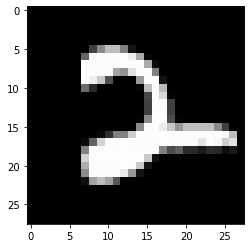

In [8]:
image,label=train_ds[0]
plt.imshow(image[0],cmap='gray')
print('Label: ',label)

In [16]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear=nn.Linear(input_size,num_classes)
  
  def forward(self,xb):
    xb=xb.reshape(-1,784)
    out=self.linear(xb)
    return out

  def training_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels=batch
    out=self(images)
    loss=F.cross_entropy(out,labels)
    acc=accuracy(out,labels)
    return {'val_loss': loss.detach(),'val_acc': acc.detach()}

  def validation_epoch_end(self,outputs):
    batch_losses=[x['val_loss']for x in outputs]
    epoch_loss=torch.stack(batch_losses).mean()
    batch_accs=[x['val_acc']for x in outputs]
    epoch_acc=torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc'])) 

model=MnistModel()

In [17]:
def accuracy(outputs,labels):
  _,preds=torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [18]:
def evaluate(model,val_loader):
  outputs=[model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)
  
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
  history=[]
  optimizer=opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    for batch in train_loader:
      loss=model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result=evaluate(model,val_loader)
    model.epoch_end(epoch,result)
    history.append(result)
  return history

In [19]:
evaluate(model,val_loader)

{'val_acc': 0.11308594048023224, 'val_loss': 2.330047130584717}

In [20]:
history=fit(20,0.0001,model,train_loader,val_loader)

Epoch [0], val_loss: 2.2842, val_acc: 0.1698
Epoch [1], val_loss: 2.2408, val_acc: 0.2382
Epoch [2], val_loss: 2.1995, val_acc: 0.3174
Epoch [3], val_loss: 2.1599, val_acc: 0.3897
Epoch [4], val_loss: 2.1220, val_acc: 0.4460
Epoch [5], val_loss: 2.0854, val_acc: 0.4895
Epoch [6], val_loss: 2.0501, val_acc: 0.5283
Epoch [7], val_loss: 2.0160, val_acc: 0.5601
Epoch [8], val_loss: 1.9830, val_acc: 0.5841
Epoch [9], val_loss: 1.9510, val_acc: 0.6064
Epoch [10], val_loss: 1.9200, val_acc: 0.6223
Epoch [11], val_loss: 1.8900, val_acc: 0.6372
Epoch [12], val_loss: 1.8608, val_acc: 0.6538
Epoch [13], val_loss: 1.8326, val_acc: 0.6664
Epoch [14], val_loss: 1.8051, val_acc: 0.6758
Epoch [15], val_loss: 1.7785, val_acc: 0.6846
Epoch [16], val_loss: 1.7526, val_acc: 0.6917
Epoch [17], val_loss: 1.7275, val_acc: 0.6998
Epoch [18], val_loss: 1.7032, val_acc: 0.7050
Epoch [19], val_loss: 1.6795, val_acc: 0.7121


In [28]:
history1=fit(5,0.001,model,train_loader,val_loader)

Epoch [0], val_loss: 1.1874, val_acc: 0.7976
Epoch [1], val_loss: 1.0996, val_acc: 0.8078
Epoch [2], val_loss: 1.0288, val_acc: 0.8161
Epoch [3], val_loss: 0.9706, val_acc: 0.8227
Epoch [4], val_loss: 0.9221, val_acc: 0.8267


Text(0.5, 1.0, 'Accuracy vs No. of epochs')

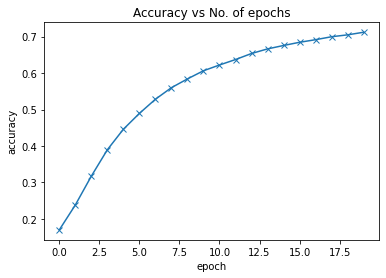

In [23]:
accuracies=[r['val_acc']for r in history]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')

In [25]:
result=evaluate(model,test_loader)

In [26]:
result

{'val_acc': 0.7847656011581421, 'val_loss': 1.2863705158233643}

In [29]:
jovian.log_metrics(test_acc=result['val_acc'],test_loss=result['val_loss'])

[jovian] Metrics logged.


In [30]:
def predict_image(img,model):
  xb=img.squeeze(0)
  yb=model(xb)
  _,preds=torch.max(yb,dim=1)
  return preds[0].item()

Label:  4 Predicted:  1


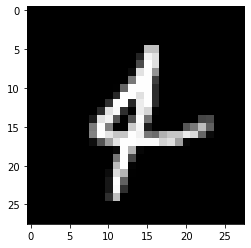

In [31]:
img,label=test_ds[300]
plt.imshow(img[0],cmap='gray')
print("Label: ", label,"Predicted: ",predict_image(img,model))

Label:  1 Predicted:  1


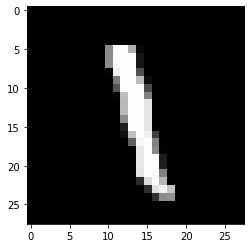

In [32]:
img,label=test_ds[700]
plt.imshow(img[0],cmap='gray')
print("Label: ", label,"Predicted: ",predict_image(img,model))

In [33]:
torch.save(model.state_dict(),'mnist-logistic.pth')

In [ ]:
jovian.commit(project='logistic-regression-model',environment=None,)